# 02 - Подготовка и разметка данных

## Создание датасета для детекции факелов

**Цель:** Подготовить размеченный датасет в формате YOLO для обучения модели детекции.

## 1. Настройка окружения и импорт библиотек

In [ ]:
import sys
import os
from pathlib import Path
import yaml
import json
import shutil
from typing import Dict, List, Tuple, Optional

In [29]:
from pathlib import Path
import sys
# Добавляем src в путь
project_root = Path.cwd().parent
src_path = project_root / "src"
sys.path.append(str(src_path))

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
import cv2
from tqdm.auto import tqdm
import random
from sklearn.model_selection import train_test_split

In [24]:
import sys
from pathlib import Path

# Вручную укажите путь к вашему проекту
PROJECT_PATH = Path("E:\Python\MIFI\project-practice")  # или укажите абсолютный путь, например Path("/home/user/project")

# Добавляем путь
sys.path.insert(0, str(PROJECT_PATH))

# Пытаемся импортировать
try:
    from src.utils.config import load_config
    from src.utils.helpers import create_directory, get_image_files
    print("✅ Успешный импорт!")
except ImportError as e:
    print(f"❌ Ошибка: {e}")
    # Создаем заглушки
    def load_config(*args, **kwargs): return {}
    def create_directory(p): Path(p).mkdir(parents=True, exist_ok=True); return Path(p)
    def get_image_files(d, e=None): return []

✅ Успешный импорт!


In [25]:
# Загрузка конфигурации
from pathlib import Path
import yaml

PROJECT_PATH = Path("E:\Python\MIFI\project-practice") 

# Загрузка конфигурации
config_path = PROJECT_PATH / "configs" / "paths.yaml"

with open(config_path, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)
    print("✅ Конфигурация успешно загружена (UTF-8)")

✅ Конфигурация успешно загружена (UTF-8)


## 2. Сбор и организация исходных данных

In [30]:
from typing import Dict
from src.utils.helpers import create_directory, get_image_files
project_root = Path.cwd().parent

def collect_all_images(config: Dict) -> Dict[str, list[Path]]:
    """Собирает все изображения из разных источников"""
    print("Сбор изображений из всех источников...")
    
    image_sources = {
        'raw': get_image_files(Path(config['data']['raw'])),
        'external': get_image_files(Path(config['data']['external'])),
        'flaring_gas': get_image_files(project_root / "flaring-gas")
    }
    
    # Выводим статистику
    print("\n📊 СТАТИСТИКА ПО ИСТОЧНИКАМ:")
    total_images = 0
    for source, images in image_sources.items():
        count = len(images)
        total_images += count
        print(f"  {source}: {count} изображений")
    
    print(f"\n📈 ВСЕГО: {total_images} изображений")
    
    return image_sources

In [31]:
image_sources = collect_all_images(config)

Сбор изображений из всех источников...

📊 СТАТИСТИКА ПО ИСТОЧНИКАМ:
  raw: 0 изображений
  external: 0 изображений
  flaring_gas: 1052 изображений

📈 ВСЕГО: 1052 изображений


## 3. Просмотр и отбор изображений с факелами

In [33]:
import shutil

def create_labeling_interface(images: list[Path], output_dir: Path):
    """Создает интерфейс для разметки изображений"""
    
    # Создаем директории для разметки
    labeling_dir = output_dir / "for_labeling"
    create_directory(labeling_dir)
    
    print(f"\nСоздание интерфейса для разметки в {labeling_dir}")
    print(f"Будет скопировано {len(images)} изображений")
    
    # Копируем изображения
    for idx, img_path in enumerate(tqdm(images, desc="Копирование изображений")):
        dst_path = labeling_dir / f"image_{idx:04d}{img_path.suffix}"
        shutil.copy2(img_path, dst_path)
    
    # Создаем инструкцию
    instruction = labeling_dir / "INSTRUCTIONS.txt"
    with open(instruction, 'w', encoding='utf-8') as f:
        f.write("=" * 60 + "\n")
        f.write("ИНСТРУКЦИЯ ПО РАЗМЕТКЕ ФАКЕЛОВ\n")
        f.write("=" * 60 + "\n\n")
        f.write("1. Используйте инструмент разметки (LabelImg, CVAT, Roboflow Annotate)\n")
        f.write("2. Класс для разметки: 'flare'\n")
        f.write("3. Обводите ВЕСЬ видимый факел (пламя + дым если виден)\n")
        f.write("4. Для калибровочных изображений добавьте второй класс: 'flare_calibrated'\n")
        f.write("5. Сохраняйте разметку в формате YOLO (.txt файлы)\n\n")
        f.write("Имена файлов должны совпадать:\n")
        f.write("  image_0001.jpg -> image_0001.txt\n")
    
    print(f"\n✅ Готово! Файлы для разметки в: {labeling_dir}")
    print(f"📋 Инструкция: {instruction}")

In [ ]:
import random
# Отбираем случайные изображения для разметки (первые 100)
sample_images = []
for source_images in image_sources.values():
    sample_images.extend(source_images[:50])  # Берем по 50 из каждого источника

random.seed(42)
sample_images = random.sample(sample_images, min(100, len(sample_images)))

# Создаем интерфейс для разметки
labeling_output = project_root / "data" / "interim" / "labeling"
create_labeling_interface(sample_images, labeling_output)


Создание интерфейса для разметки в e:\Python\MIFI\project-practice\data\interim\labeling\for_labeling
Будет скопировано 50 изображений


Копирование изображений:   0%|          | 0/50 [00:00<?, ?it/s]


✅ Готово! Файлы для разметки в: e:\Python\MIFI\project-practice\data\interim\labeling\for_labeling
📋 Инструкция: e:\Python\MIFI\project-practice\data\interim\labeling\for_labeling\INSTRUCTIONS.txt


## 4. Загрузка и проверка размеченных данных

In [78]:
def load_coco_annotations(coco_json_path: Path) -> pd.DataFrame:
    """Загружает аннотации в формате COCO JSON"""
    
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    
    annotations = []
    
    # Создаем словарь для быстрого поиска
    images_dict = {img['id']: img for img in coco_data['images']}
    categories_dict = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    for ann in tqdm(coco_data['annotations'], desc="Загрузка COCO аннотаций"):
        img_info = images_dict[ann['image_id']]
        
        # COCO формат: [x_min, y_min, width, height]
        x_min, y_min, width, height = ann['bbox']
        x_max = x_min + width
        y_max = y_min + height
        x_center = x_min + width / 2
        y_center = y_min + height / 2
        
        annotations.append({
            'image_id': ann['image_id'],
            'image_name': img_info['file_name'],
            'image_width': img_info['width'],
            'image_height': img_info['height'],
            'class_id': ann['category_id'],
            'class_name': categories_dict[ann['category_id']],
            'x_center': x_center,
            'y_center': y_center,
            'width': width,
            'height': height,
            'x_min': x_min,
            'y_min': y_min,
            'x_max': x_max,
            'y_max': y_max,
            'area': ann['area'],
            'aspect_ratio': width / height if height > 0 else 0,
            'bbox': ann['bbox'],  # оригинальный COCO bbox
            'iscrowd': ann['iscrowd']
        })
    
    return pd.DataFrame(annotations)


In [79]:
df = load_coco_annotations(Path("E:\\Python\\MIFI\\project-practice\\data\\interim\\labeled\\labels\\_annotations.coco.json"))

Загрузка COCO аннотаций:   0%|          | 0/48 [00:00<?, ?it/s]

In [80]:
def load_multiple_coco_datasets(base_dir: Path):
    """Загружает несколько COCO датасетов"""
    
    datasets = {}
    coco_files = {
        'train': base_dir /"train"/'_annotations.coco.json',
        'valid': base_dir /"valid"/'_annotations.coco.json',
        'test': base_dir /"test"/'_annotations.coco.json'
    }
    
    for dataset_name, coco_path in coco_files.items():
        if coco_path.exists():
            print(f"\nЗагрузка {dataset_name} датасета...")
            df = load_coco_annotations(coco_path)
            df['dataset'] = dataset_name
            datasets[dataset_name] = df
            print(f"✅ {dataset_name}: {len(df)} аннотаций, {df['image_name'].nunique()} изображений")
        else:
            print(f"⚠️ {dataset_name} COCO файл не найден: {coco_path}")
    
    # Объединяем все датасеты
    if datasets:
        combined_df = pd.concat(datasets.values(), ignore_index=True)
        return combined_df, datasets
    else:
        return pd.DataFrame(), {}

In [81]:

# Используем:
base_dir = Path("E:\\Python\MIFI\\project-practice\\flaring-gas\\")
df_combined, datasets_dict = load_multiple_coco_datasets(base_dir)


Загрузка train датасета...


Загрузка COCO аннотаций:   0%|          | 0/2319 [00:00<?, ?it/s]

✅ train: 2319 аннотаций, 987 изображений

Загрузка valid датасета...


Загрузка COCO аннотаций:   0%|          | 0/97 [00:00<?, ?it/s]

✅ valid: 97 аннотаций, 40 изображений

Загрузка test датасета...


Загрузка COCO аннотаций:   0%|          | 0/48 [00:00<?, ?it/s]

✅ test: 48 аннотаций, 19 изображений


## 5. Визуализация размеченных данных

In [89]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_coco_annotation(df, base_dir, n_samples=3, dataset_type='train'):
    """Визуализирует аннотации из COCO датасета с учетом подпапок"""
    
    # Фильтруем по типу датасета
    if dataset_type in df['dataset'].unique():
        df_filtered = df[df['dataset'] == dataset_type]
    else:
        print(f"⚠️ Датасет {dataset_type} не найден в данных")
        df_filtered = df
    
    if df_filtered.empty:
        print(f"⚠️ Нет данных для визуализации (датасет: {dataset_type})")
        return
    
    unique_images = df_filtered['image_name'].unique()[:n_samples]
    
    fig, axes = plt.subplots(1, min(len(unique_images), n_samples), figsize=(15, 5))
    if len(unique_images) == 1:
        axes = [axes]
    elif len(unique_images) == 0:
        print("⚠️ Нет изображений для визуализации")
        return
    
    for ax, img_name in zip(axes, unique_images):
        # Определяем путь к изображению в зависимости от датасета
        img_dataset = df_filtered[df_filtered['image_name'] == img_name]['dataset'].iloc[0]
        
        # Путь к изображению в соответствующей подпапке
        img_path = base_dir / img_dataset / img_name
        
        if not img_path.exists():
            # Попробуем найти в корневой папке
            img_path = base_dir / img_name
            if not img_path.exists():
                ax.text(0.5, 0.5, f"Файл не найден:\n{img_name}", 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"{img_name}\n(файл не найден)")
                ax.axis('off')
                continue
        
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            
            # Рисуем bounding boxes для этого изображения
            img_annotations = df_filtered[df_filtered['image_name'] == img_name]
            for _, ann in img_annotations.iterrows():
                x_min, y_min = ann['x_min'], ann['y_min']
                width, height = ann['width'], ann['height']
                
                # Цвет в зависимости от класса
                color_map = {'flare': 'red', 'fire': 'orange', 'smoke': 'gray'}
                color = color_map.get(ann['class_name'], 'blue')
                
                rect = patches.Rectangle(
                    (x_min, y_min), width, height,
                    linewidth=2, edgecolor=color, facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(x_min, y_min-5, ann['class_name'], 
                       color=color, fontsize=10, fontweight='bold',
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            
            ax.set_title(f"{img_name}\n({len(img_annotations)} объектов, {img_dataset})")
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Ошибка загрузки:\n{img_name}\n{e}", 
                   ha='center', va='center', transform=ax.transAxes)
        
        ax.axis('off')
    
    plt.suptitle(f"Визуализация аннотаций (датасет: {dataset_type})", fontsize=14)
    plt.tight_layout()
    plt.show()


In [90]:
def visualize_all_datasets(df_combined, base_dir, samples_per_dataset=2):
    """Визуализирует примеры из всех датасетов"""
    
    for dataset_type in df_combined['dataset'].unique():
        visualize_coco_annotation(df_combined, base_dir, 
                                 n_samples=samples_per_dataset, 
                                 dataset_type=dataset_type)


In [91]:
def get_image_path(row, base_dir):
    """Получает полный путь к изображению на основе датасета"""
    return str(base_dir / row['dataset'] / row['image_name'])


Загрузка train датасета...


Загрузка COCO аннотаций:   0%|          | 0/2319 [00:00<?, ?it/s]

✅ train: 2319 аннотаций, 987 изображений

Загрузка valid датасета...


Загрузка COCO аннотаций:   0%|          | 0/97 [00:00<?, ?it/s]

✅ valid: 97 аннотаций, 40 изображений

Загрузка test датасета...


Загрузка COCO аннотаций:   0%|          | 0/48 [00:00<?, ?it/s]

✅ test: 48 аннотаций, 19 изображений

✅ Всего загружено: 2464 аннотаций
✅ Уникальных изображений: 1046
✅ Распределение по датасетам:
dataset
train    2319
valid      97
test       48
Name: count, dtype: int64
✅ Распределение по классам:
class_name
fire     1436
smoke    1028
Name: count, dtype: int64

✅ Все изображения найдены в соответствующих папках

ВИЗУАЛИЗАЦИЯ АННОТАЦИЙ


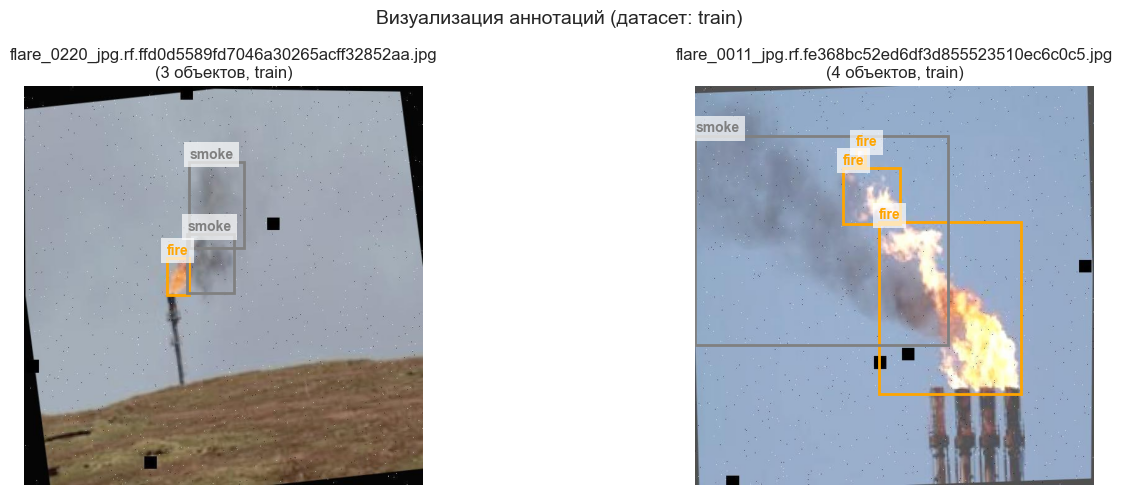

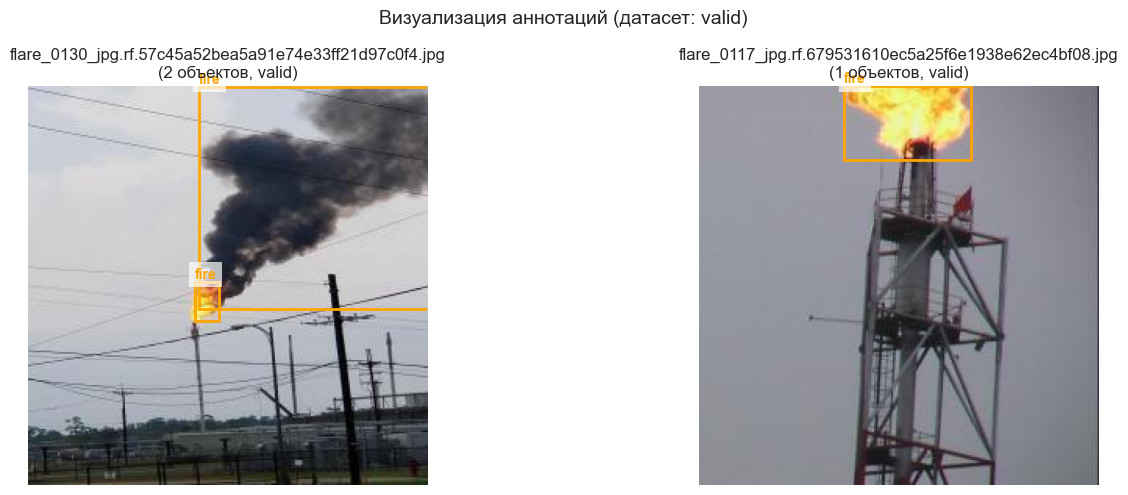

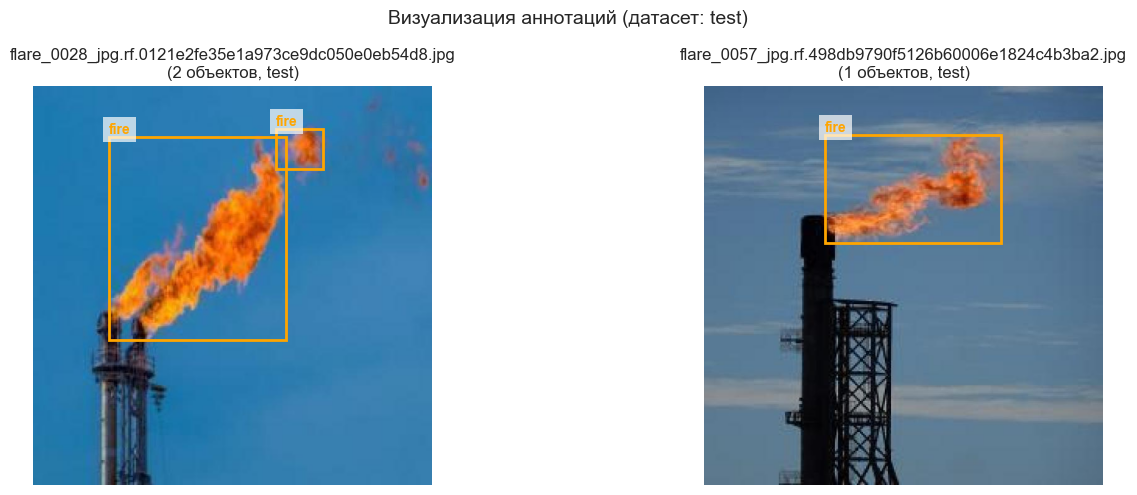

In [93]:
# Загружаем данные из всех датасетов
df_combined, datasets_dict = load_multiple_coco_datasets(base_dir)

if not df_combined.empty:
    print(f"\n✅ Всего загружено: {len(df_combined)} аннотаций")
    print(f"✅ Уникальных изображений: {df_combined['image_name'].nunique()}")
    print(f"✅ Распределение по датасетам:\n{df_combined['dataset'].value_counts()}")
    print(f"✅ Распределение по классам:\n{df_combined['class_name'].value_counts()}")
    
    # Добавляем полные пути к изображениям
    df_combined['image_path'] = df_combined.apply(
        lambda row: get_image_path(row, base_dir), axis=1
    )
    
    # Проверяем существование изображений
    missing_images = df_combined[~df_combined['image_path'].apply(lambda x: Path(x).exists())]
    if not missing_images.empty:
        print(f"\n⚠️ ВНИМАНИЕ: Не найдено {missing_images['image_name'].nunique()} изображений")
        print("   Первые 5 отсутствующих файлов:")
        for img_name in missing_images['image_name'].unique()[:5]:
            print(f"   - {img_name}")
    else:
        print(f"\n✅ Все изображения найдены в соответствующих папках")
    
    # Визуализируем примеры из всех датасетов
    print("\n" + "="*60)
    print("ВИЗУАЛИЗАЦИЯ АННОТАЦИЙ")
    print("="*60)
    
    # Визуализируем по 2 примера из каждого датасета
    visualize_all_datasets(df_combined, base_dir, samples_per_dataset=2)
    
    # Или визуализируем конкретный датасет
    # visualize_coco_annotation(df_combined, base_dir, n_samples=3, dataset_type='train')
    
else:
    print("⚠️ Нет загруженных данных. Проверьте структуру папок:")
    print(f"   {base_dir}/train/_annotations.coco.json")
    print(f"   {base_dir}/valid/_annotations.coco.json")
    print(f"   {base_dir}/test/_annotations.coco.json")


In [94]:
# Дополнительная статистика
if 'datasets_dict' in locals() and datasets_dict:
    print("\n" + "="*60)
    print("СТАТИСТИКА ПО ДАТАСЕТАМ")
    print("="*60)
    
    for dataset_name, df in datasets_dict.items():
        print(f"\n📊 {dataset_name.upper()}:")
        print(f"   Всего аннотаций: {len(df)}")
        print(f"   Уникальных изображений: {df['image_name'].nunique()}")
        print(f"   Распределение классов:")
        class_counts = df['class_name'].value_counts()
        for class_name, count in class_counts.items():
            print(f"     - {class_name}: {count} ({count/len(df)*100:.1f}%)")
        
        # Статистика по размерам bounding boxes
        if not df.empty:
            print(f"   Средний размер bbox:")
            print(f"     - Площадь: {df['area'].mean():.1f} px²")
            print(f"     - Ширина: {df['width'].mean():.1f} px")
            print(f"     - Высота: {df['height'].mean():.1f} px")


СТАТИСТИКА ПО ДАТАСЕТАМ

📊 TRAIN:
   Всего аннотаций: 2319
   Уникальных изображений: 987
   Распределение классов:
     - fire: 1349 (58.2%)
     - smoke: 970 (41.8%)
   Средний размер bbox:
     - Площадь: 52850.3 px²
     - Ширина: 188.1 px
     - Высота: 201.7 px

📊 VALID:
   Всего аннотаций: 97
   Уникальных изображений: 40
   Распределение классов:
     - fire: 58 (59.8%)
     - smoke: 39 (40.2%)
   Средний размер bbox:
     - Площадь: 57904.4 px²
     - Ширина: 209.8 px
     - Высота: 200.6 px

📊 TEST:
   Всего аннотаций: 48
   Уникальных изображений: 19
   Распределение классов:
     - fire: 29 (60.4%)
     - smoke: 19 (39.6%)
   Средний размер bbox:
     - Площадь: 54067.5 px²
     - Ширина: 208.2 px
     - Высота: 188.6 px


## 7. Анализ статистики по датасетам 

In [95]:
def prepare_yolo_dataset(df_annotations: pd.DataFrame, 
                         output_dir: Path,
                         target_size: Tuple[int, int] = (640, 640),
                         train_ratio: float = 0.7,
                         val_ratio: float = 0.2,
                         test_ratio: float = 0.1):
    """Подготавливает датасет в формате YOLO"""
    
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 0.01, "Сумма долей должна быть 1"
    
    print("\n" + "="*60)
    print("ПОДГОТОВКА ДАТАСЕТА YOLO")
    print("="*60)
    
    # Создаем директории
    splits = ['train', 'val', 'test']
    for split in splits:
        create_directory(output_dir / 'images' / split)
        create_directory(output_dir / 'labels' / split)
    
    # Уникальные изображения
    unique_images = df_annotations['image_path'].unique()
    print(f"Уникальных изображений для обработки: {len(unique_images)}")
    
    # Разделяем на train/val/test
    train_images, temp_images = train_test_split(
        unique_images, 
        train_size=train_ratio,
        random_state=42
    )
    
    val_images, test_images = train_test_split(
        temp_images,
        train_size=val_ratio/(val_ratio + test_ratio),
        random_state=42
    )
    
    print(f"\n📊 РАСПРЕДЕЛЕНИЕ:")
    print(f"  Train: {len(train_images)} изображений ({len(train_images)/len(unique_images)*100:.1f}%)")
    print(f"  Val: {len(val_images)} изображений ({len(val_images)/len(unique_images)*100:.1f}%)")
    print(f"  Test: {len(test_images)} изображений ({len(test_images)/len(unique_images)*100:.1f}%)")
    
    # Обрабатываем каждое изображение
    split_mapping = {
        'train': train_images,
        'val': val_images,
        'test': test_images
    }
    
    dataset_stats = {'train': 0, 'val': 0, 'test': 0}
    
    for split_name, split_images in split_mapping.items():
        print(f"\nОбработка {split_name} выборки...")
        
        for img_path in tqdm(split_images, desc=f"{split_name}"):
            img_path = Path(img_path)
            
            try:
                # Загружаем изображение
                img = Image.open(img_path)
                orig_width, orig_height = img.size
                
                # Resize с сохранением соотношения сторон
                img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
                
                # Сохраняем изображение
                img_filename = f"{img_path.stem}{img_path.suffix}"
                img_save_path = output_dir / 'images' / split_name / img_filename
                img_resized.save(img_save_path)
                
                # Получаем аннотации для этого изображения
                img_annotations = df_annotations[df_annotations['image_path'] == str(img_path)]
                
                # Создаем файл с аннотациями
                label_save_path = output_dir / 'labels' / split_name / f"{img_path.stem}.txt"
                
                with open(label_save_path, 'w') as f:
                    for _, ann in img_annotations.iterrows():
                        # Конвертируем координаты в YOLO формат (нормализованные)
                        x_center = ann['x_center'] / orig_width
                        y_center = ann['y_center'] / orig_height
                        width = ann['width'] / orig_width
                        height = ann['height'] / orig_height
                        
                        # Записываем в формате: class_id x_center y_center width height
                        f.write(f"{ann['class_id']} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                
                dataset_stats[split_name] += len(img_annotations)
                
            except Exception as e:
                print(f"Ошибка при обработке {img_path}: {e}")
    
    # Создаем файл конфигурации датасета
    create_dataset_config(output_dir, splits, dataset_stats, target_size)
    
    return dataset_stats


АНАЛИЗ СТАТИСТИКИ ВСЕХ ДАННЫХ

СТАТИСТИКА АННОТАЦИЙ

📊 ОСНОВНЫЕ МЕТРИКИ:
  Всего аннотаций: 2464
  Уникальных изображений: 1046
  Среднее аннотаций на изображение: 2.36

🏷️ РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ:
  fire: 1436 (58.3%)
  smoke: 1028 (41.7%)

📏 РАЗМЕРЫ BOUNDING BOXES:
  Средняя площадь: 53073.0 пикселей²
  Мин площадь: 36.0
  Макс площадь: 409146.7
  Среднее соотношение сторон: 1.02

🖼️ РАЗМЕРЫ ИЗОБРАЖЕНИЙ:
  Уникальных размеров: 1
  Частые размеры:
    640x640: 2464 аннотаций


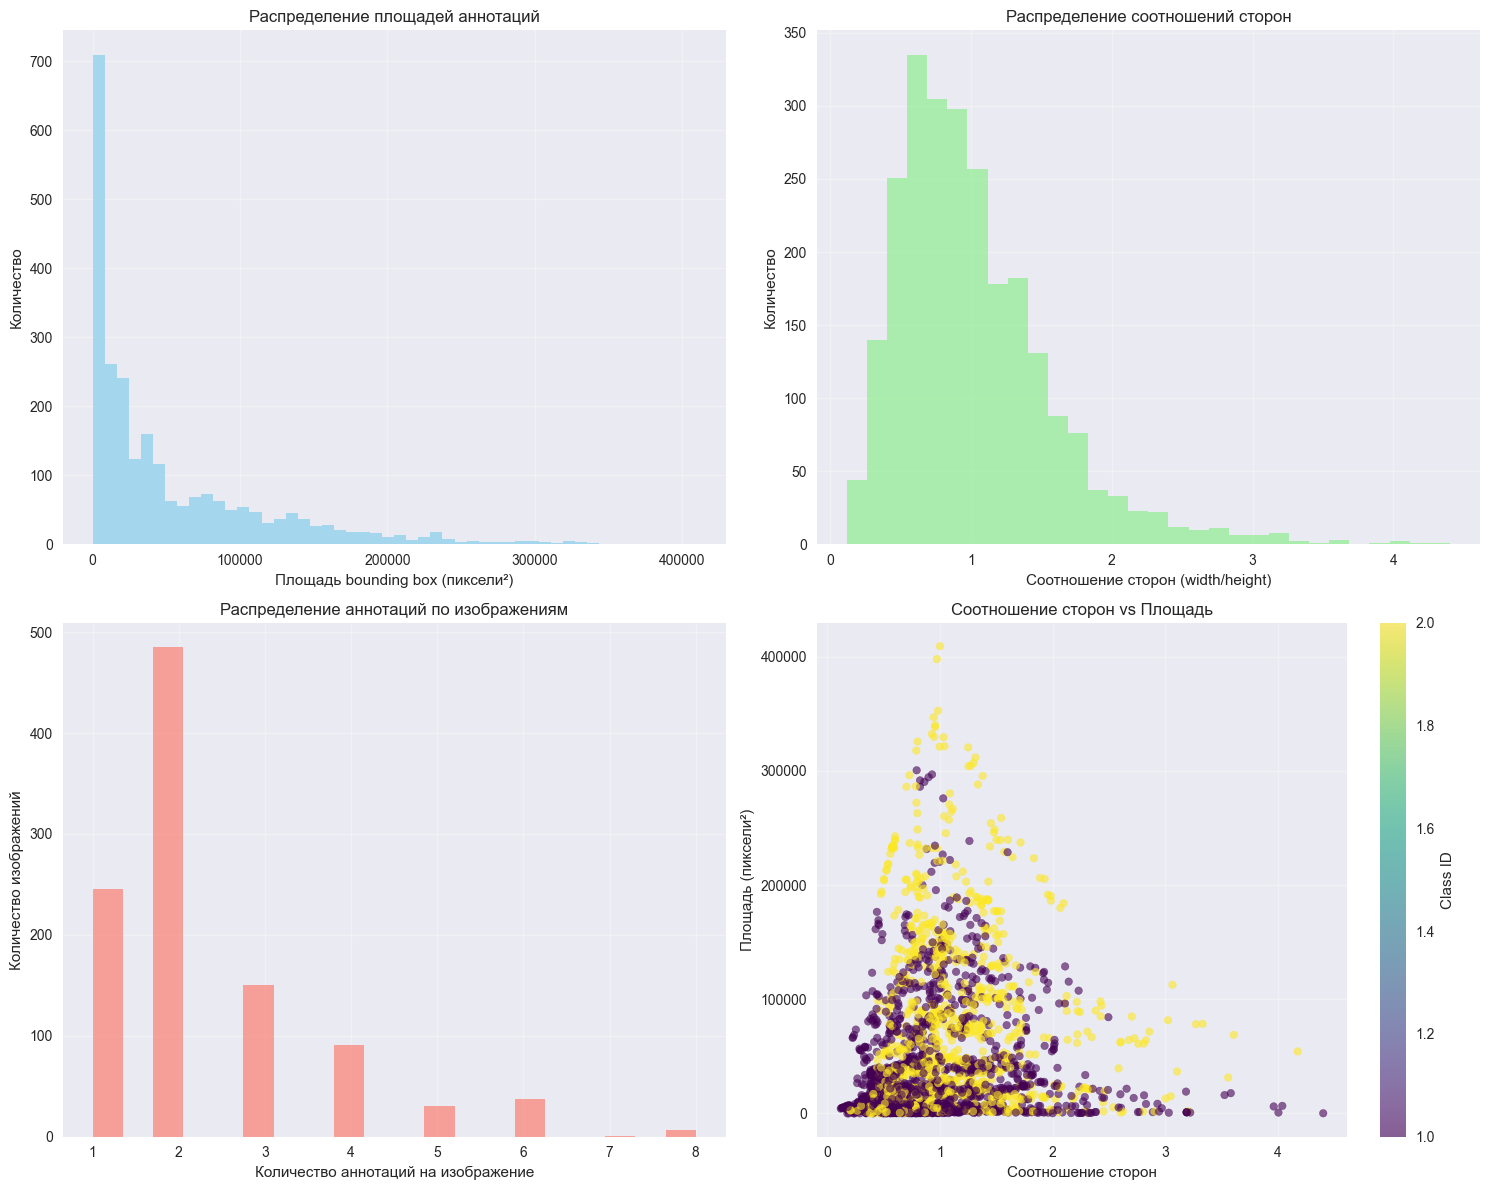


РЕЗУЛЬТАТЫ АНАЛИЗА

✅ Анализ завершен успешно!

📈 ОСНОВНЫЕ РЕЗУЛЬТАТЫ:
  • Всего аннотаций: 2464
  • Уникальных изображений: 1046
  • Среднее аннотаций на изображение: 2.36

🏷️ РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ:
  • fire: 1436 (58.3%)
  • smoke: 1028 (41.7%)

📏 СТАТИСТИКА РАЗМЕРОВ:
  • Средняя площадь: 53073.0 px²
  • Диапазон: 36.0 - 409146.7 px²

💾 Результаты сохранены в переменной 'stats_results'


In [96]:
print("\n" + "="*60)
print("АНАЛИЗ СТАТИСТИКИ ВСЕХ ДАННЫХ")
print("="*60)

# Анализируем все данные
if not df_combined.empty:
    stats_results = analyze_annotations_statistics(df_combined)
    
    print("\n" + "="*60)
    print("РЕЗУЛЬТАТЫ АНАЛИЗА")
    print("="*60)
    
    if stats_results:
        print(f"\n✅ Анализ завершен успешно!")
        print(f"\n📈 ОСНОВНЫЕ РЕЗУЛЬТАТЫ:")
        print(f"  • Всего аннотаций: {stats_results['total_annotations']}")
        print(f"  • Уникальных изображений: {stats_results['unique_images']}")
        print(f"  • Среднее аннотаций на изображение: {stats_results['avg_annotations_per_image']:.2f}")
        
        if 'dataset_distribution' in stats_results:
            print(f"\n📊 РАСПРЕДЕЛЕНИЕ ПО ДАТАСЕТАМ:")
            for dataset, count in stats_results['dataset_distribution'].items():
                print(f"  • {dataset}: {count} аннотаций")
        
        print(f"\n🏷️ РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ:")
        for class_name, count in stats_results['class_distribution'].items():
            percentage = (count / stats_results['total_annotations']) * 100
            print(f"  • {class_name}: {count} ({percentage:.1f}%)")
        
        print(f"\n📏 СТАТИСТИКА РАЗМЕРОВ:")
        print(f"  • Средняя площадь: {stats_results['area_stats']['mean']:.1f} px²")
        print(f"  • Диапазон: {stats_results['area_stats']['min']:.1f} - {stats_results['area_stats']['max']:.1f} px²")
        
        print(f"\n💾 Результаты сохранены в переменной 'stats_results'")
else:
    print("⚠️ Нет данных для анализа статистики")